Vedant Singh Rathore
<br>Hackathon

## Importing necessary libraries and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os

# For Data Treatment
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox

# Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,recall_score, make_scorer
from sklearn import tree

# For tuning the model
from sklearn.model_selection import GridSearchCV
import datetime

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

# os.chdir('/Users/vedantrathore/VSCode Working Folder/mit_idss/shinka_travel_exp_hackathon/')÷

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [4]:
train_data_path = '/content/drive/MyDrive/IDSS/data/train/'
test_data_path = '/content/drive/MyDrive/IDSS/data/test/'
kaggle_path = '/kaggle/input/hackathon/'


survey_train = pd.read_csv(kaggle_path+'Surveydata_train.csv')
travel_train = pd.read_csv(kaggle_path+'Traveldata_train.csv')

survey_test = pd.read_csv(kaggle_path+'Surveydata_test.csv')
travel_test = pd.read_csv(kaggle_path+'Traveldata_test.csv')

In [5]:
train_df = pd.merge(travel_train, survey_train, on='ID', how='left')
df = train_df.copy()

test_df = pd.merge(travel_test, survey_test, on='ID', how='left')
out_df = test_df.copy()

In [6]:
target_col = 'Overall_Experience'
id_col = 'ID'

## Data Overview

- Observations
- Sanity checks

In [7]:
### First 5 rows
# df.head()

In [8]:
#### Print Rows and Columns
print(f'Rows: {df.shape[0]}')
print(f'Columns: {df.shape[1]}')

Rows: 129981
Columns: 25


In [9]:
### Checking info of the data ###
# df.info()

## Exploratory Data Analysis (EDA)

In [10]:
## Filter Numeric Columns from the dataframe
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()
## Drop target columns
numeric_columns.remove(id_col)

columns = list(df.columns)
columns.remove(id_col)

In [11]:
# ### Summary of Categorical Columns
# ## df.describe method can be used to print the statistical summary of the data
# ## include='object' argument provides the summary for ordinal columns
# df.describe(include='object').T

In [12]:
# ### Summary of Numerical Columns
# df.describe().T

**Univariate Analysis**

In [13]:
## Create a univariate analysis function that takes the dataframe, the column to be analyzed and a flag to check if the column is an id column
## This function can be used to analyze all the columns in the data without rewriting any piece of plotting code
def uni_analyze(df,col,id_col=False):
  print("-"*300)
  print(f'\nUnivariate Analysis of {col}\n')
  """Check if the given column is an id column"""
  if id_col==False:
    """If not an id column, check if the column is of 'object' dtype"""
    if df[col].dtype=='object':
      """Print the value counts for the column"""
      print(f'Unique Set of Values for {col}:\n{df[col].value_counts()}\n')
      plt.figure(figsize = (15,5))
      """If the number of unique entries in the column is less than 20, Plot the countplot"""
      """Too many unique values will lead to crowding of the plot"""
      if df[col].nunique()<20:
        fig = sns.countplot(data = df, x = col)
        for patch in fig.patches:
          label = patch.get_height()
          x = patch.get_x() + patch.get_width() / 2  # width of the plot
          y = patch.get_height()
          fig.annotate(label,(x,y))
      else:
        print('\nToo many distinct variables to be plotted on a countplot!!')
      plt.show()

    else:
      """If not an 'object' column, i.e. for numeric columns"""
      """Print the Mean, Median, Min, Max and Skew of the column"""
      print(f'Stats for the column {col}:\n Mean: {df[col].mean()}\n Min: {df[col].min()}\n Max: {df[col].max()}\n Median: {df[col].median()}\n Skew: {df[col].skew()}\n')

      f, (hist_plot, box_plot) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.75, 0.25)},
        figsize=(15,5)
      )
      """Subplot Histogram of the column"""
      sns.histplot(data=df,x=col, ax=hist_plot, kde=False) ## Histogram
      """Plot the boxplot of the column"""
      sns.boxplot(data=df,x=col, ax=box_plot) ## Boxplot
      """Add Mean to histogram"""
      hist_plot.axvline(df[col].mean())
      """Add Median to histplot"""
      hist_plot.axvline(df[col].mean())
      f.suptitle(f'Boxplot & Histogram for {col}')
      plt.show()

  else:
    """If an ID column, show the total number of unique counts in the column and print sample data"""
    print(f'Unique Values for {col}:\n{df[col].nunique()}')
    print(f'\n Sample data\n')
    print(df[col].head())

In [14]:
# ## To Analyze All Columns in a single output block
# ## Creating an analyze function helps iterate over the df.columns list and print all outputs in one output block
# for column in categorical_columns:
#   uni_analyze(df,column)

In [15]:
# ## To Analyze All Columns in a single output block
# ## Creating an analyze function helps iterate over the df.columns list and print all outputs in one output block
# for column in numeric_columns:
#   uni_analyze(df,column)

**Multivariate Analysis**

In [16]:
## Barplots and distplots are some of the best plots for multivariate analysis
### Distribution Plot
def distribution_plot(data, predictor, target):

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

    target_uniq = data[target].unique()

    axs[0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0],
        color="teal",
        stat="density",
    )

    axs[1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[1],
        color="orange",
        stat="density",
    )

    plt.show()
### Bar Plot
def bar_plot(df,feature, target):
    plt.figure(figsize=(15,7))
    ## Get feature wise percentage split of converting and non-converting
    plot_df = pd.crosstab(df[feature], df[target]).sort_values(by=df[target].value_counts().index[-1], ascending=False)
    plot_df.plot(kind="bar", stacked=True)
    plt.xticks(rotation = 60)
    plt.show()

## Create a dataframe to observe the conversion rate basis given column
def check_conversion_split(df,col,target):
  temp_df = df.groupby([col,target]).agg({'ID':'count'}).reset_index()
  temp_df = temp_df.pivot(index=col, columns=target, values='ID').reset_index()
  temp_df['conversion_rate'] = temp_df[1]*100/(temp_df[0]+temp_df[1])
  return temp_df

## This functions take the dataframe and the feature & target columns as input and outputs the stacked barplot and distribution plots
## Rather than rewriting the code for each pair of variables, this function can be reused with different col_list to get desired output
def multi_analyze(df,feature, target):
  bar_plot(df,feature, target)
  print("-"*300)
  distribution_plot(data=df,predictor=feature,target=target)
  check_conversion_split(df,feature,target)

**Correlation Matrix**

In [17]:
# ## Plot Correlation Matrix
# corr_columns = df.select_dtypes(include=np.number).columns.tolist()

# plt.figure(figsize=(12, 7))
# sns.heatmap(
#     df[corr_columns].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
# plt.show()

In [18]:
# for col in categorical_columns:
#     multi_analyze(df, col, target_col)

## Data Preprocessing

- Missing value treatment (if needed): **No missing value**
- Feature engineering (if needed): **Carried out below**
- Outlier detection and treatment (if needed): **Carried out below**
- Preparing data for modeling: **Carried out below**

### Treatment and Transformations

In [19]:
def fill_na(data):
    for col in data.columns:
        if col in categorical_columns:
            mode = data[col].mode().values[0]
            data[col].fillna(mode, inplace=True)
        else:
            mean = data[col].mean()
            data[col].fillna(mean, inplace=True)

    return data


In [20]:
df = fill_na(df)
# df = df.dropna()

In [21]:
out_df = fill_na(test_df)

**Outlier Treatment**

In [22]:
numeric_columns

['Age',
 'Travel_Distance',
 'Departure_Delay_in_Mins',
 'Arrival_Delay_in_Mins',
 'Overall_Experience']

In [23]:
outlier_columns = numeric_columns
outlier_columns.remove(target_col)

In [24]:
# ### Cap extreme values at 5th and 95th percentile

# def cap_column_values(df, column_name):
#     # Calculate the 5th and 95th percentiles
#     lower_bound = df[column_name].quantile(0.05)
#     upper_bound = df[column_name].quantile(0.95)

#     # Cap the column values between the percentiles
#     df[column_name] = df[column_name].clip(lower=lower_bound, upper=upper_bound)
#     return df

# for col in numeric_columns:
#   df = cap_column_values(df,col)
#   out_df = cap_column_values(out_df,col)

**Creating dummy variables for categorical Variables**

In [25]:
# Creating dummy variables
df = pd.get_dummies(data = df, columns = categorical_columns, drop_first = True)
out_df = pd.get_dummies(data = out_df, columns = categorical_columns, drop_first = True)

drop_cols = list(set(df.columns)-set(out_df.columns))
drop_cols.remove(target_col)
df = df.drop(columns=drop_cols, axis=0)

**Removing Skewness**

In [26]:
## Check Skewness in the data
for col in numeric_columns:
  print(col, df[col].skew())

Age -0.003578621198356177
Travel_Distance 0.4669007673538273
Departure_Delay_in_Mins 6.824221891998848
Arrival_Delay_in_Mins 6.683054882320327


In [27]:
## Check Skewness in the data
for col in numeric_columns:
  print(col, out_df[col].skew())

Age -0.006735124138952123
Travel_Distance 0.450574704768844
Departure_Delay_in_Mins 5.919726181513507
Arrival_Delay_in_Mins 5.868436962584243


In [28]:
# def remove_skewness(df, column_name):
#     # Apply transformation to the specified column
#     if df[column_name].skew()>=0:
#       df[column_name] = np.sqrt(df[column_name])
#     else:
#       transformed_data, _ = boxcox(df[column_name])
#       df[column_name] = transformed_data

#     return df


# for col in numeric_columns:
#   df = remove_skewness(df,col)

**Define X, Y, Test and Train**

In [ ]:
X = df.drop([target_col,id_col], axis=1)
out_df = out_df.drop([id_col], axis=1)
Y = df[target_col]


## Enable Stratified Sampling while performing split using stratify argument
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

**Scaling the data**

In [ ]:
# Scaling the data
sc=StandardScaler()

# Fit_transform on train data
X_train_scaled=sc.fit_transform(X_train)
X_train=pd.DataFrame(X_train_scaled, columns=X.columns)

# Transform on test data
X_test_scaled=sc.transform(X_test)
X_test=pd.DataFrame(X_test_scaled, columns=X.columns)

out_df_scaled = sc.transform(out_df)
out_df = pd.DataFrame(out_df_scaled, columns=X.columns)

In [ ]:
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

**Define Function to Calculate Performance Metrics**

In [ ]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted, digits=3))
    # conf_mat = confusion_matrix(actual, predicted)

    # # plt.figure(figsize = (8, 5))
    # # sns.heatmap(conf_mat, annot = True,  fmt = '.2f', xticklabels = ['Not Converted', 'Converted'], yticklabels = ['Not Converted', 'Converted'])
    # # plt.ylabel('Actual')
    # # plt.xlabel('Predicted')
    # # plt.show()

# NN

In [ ]:
# pip install keras_tuner

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import random
from tensorflow.keras import backend
from tensorflow import keras
from tensorflow.keras import layers
# from keras_tuner import RandomSearch
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
def create_model_v7(lr,batch_size):
    np.random.seed(1337)
    model = Sequential()
    model.add(Dense(256,activation='relu',input_dim = X_train.shape[1]))
    model.add(Dropout(0.3))
    #model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.3))
#     model.add(Dense(128,activation='relu'))
#     model.add(Dropout(0.2))
    #model.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
#     model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
keras_estimator = KerasClassifier(build_fn=create_model_v7, verbose=1)

In [ ]:
# param_grid = {
#     'batch_size':[32, 64, 128],
#     'lr':[0.001, 0.01,0.1],}

# kfold_splits = 5
# grid = GridSearchCV(estimator=keras_estimator,
#                     verbose=1,
#                     cv=kfold_splits,
#                     param_grid=param_grid
#                     ,n_jobs=-1)
# grid_result = grid.fit(X_train, y_train,validation_split=0.2,verbose=1)

In [ ]:
from tensorflow.keras.optimizers import SGD, RMSprop


param_grid = {
    'batch_size': [32, 64, 128],
    'lr': [0.001, 0.01, 0.1],
    'dropout_rate': [0.2, 0.3],
    'units': [64, 128, 256],
    'hidden_layers': [3],
    'optimizer': [SGD(),'adam'],
    'loss': ['binary_crossentropy', 'hinge', 'sparse_categorical_crossentropy']
    # Add more hyperparameters here as needed
}

In [ ]:
# # Summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

In [173]:
batch_size_n = 128
lr_n = 0.001
loss = 'binary_crossentropy'
epochs = 20

In [180]:
estimator_v7=create_model_v7(batch_size=batch_size_n,lr=lr_n)
optimizer = tf.keras.optimizers.Adam(lr_n)
estimator_v7.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
history_7=estimator_v7.fit(X, Y, epochs=epochs, batch_size = batch_size_n, verbose=1, validation_split=0.1)

Epoch 1/20
914/914 [==============================] - 6s 6ms/step - loss: 1.4010 - accuracy: 0.5392 - val_loss: 0.6912 - val_accuracy: 0.5331
Epoch 2/20
914/914 [==============================] - 5s 5ms/step - loss: 0.6978 - accuracy: 0.5436 - val_loss: 0.6913 - val_accuracy: 0.5331
Epoch 3/20
914/914 [==============================] - 5s 6ms/step - loss: 0.6927 - accuracy: 0.5442 - val_loss: 0.6911 - val_accuracy: 0.5331
Epoch 4/20
914/914 [==============================] - 5s 5ms/step - loss: 0.6918 - accuracy: 0.5442 - val_loss: 0.6911 - val_accuracy: 0.5331
Epoch 5/20
914/914 [==============================] - 5s 5ms/step - loss: 0.6905 - accuracy: 0.5441 - val_loss: 0.6912 - val_accuracy: 0.5331
Epoch 6/20
914/914 [==============================] - 5s 5ms/step - loss: 0.6896 - accuracy: 0.5442 - val_loss: 0.6912 - val_accuracy: 0.5331
Epoch 7/20
914/914 [==============================] - 5s 5ms/step - loss: 0.6898 - accuracy: 0.5443 - val_loss: 0.6914 - val_accuracy: 0.5331
Epoch 

KeyboardInterrupt: 

In [175]:
# estimator_v7=create_model_v7(batch_size=grid_result.best_params_['batch_size'],lr=grid_result.best_params_['lr'])
# optimizer = tf.keras.optimizers.Adam(grid_result.best_params_['lr'])
# estimator_v7.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
# history_7=estimator_v7.fit(X_train, y_train, epochs=15, batch_size = grid_result.best_params_['batch_size'], verbose=1, validation_split=0.2)

In [176]:
from sklearn.metrics import roc_curve

# predict probabilities
yhat10 = estimator_v7.predict(X_test)
# keep probabilities for the positive outcome only
# yhat10 = yhat10[:, 0]
# calculate roc curves
fpr, tpr, thresholds10 = roc_curve(y_test, yhat10)
# calculate the g-mean for each threshold
gmeans10 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans10)

1219/1219 [==============================] - 2s 1ms/step


In [177]:
y_pred_e10=estimator_v7.predict(X_test)
y_pred_e10 = (y_pred_e10 > thresholds10[ix])
cr10=metrics.classification_report(y_test,y_pred_e10,digits=4)
print(cr10)

1219/1219 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0     0.9462    0.9729    0.9593     17814
           1     0.9766    0.9534    0.9649     21181

    accuracy                         0.9623     38995
   macro avg     0.9614    0.9632    0.9621     38995
weighted avg     0.9627    0.9623    0.9624     38995



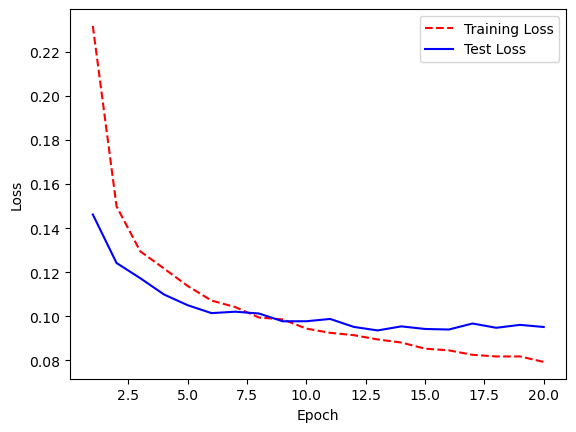

In [178]:
import matplotlib.pyplot as plt

training_loss = history_7.history['loss']
test_loss = history_7.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
from tensorflow.keras.optimizers import SGD, RMSprop

def create_model_v8(lr, dropout_rate, units, hidden_layers, optimizer, loss):
    np.random.seed(1337)
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))

    for _ in range(hidden_layers):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

keras_estimator1 = KerasClassifier(build_fn=create_model_v8, verbose=1)

In [ ]:
param_grid = {
    'batch_size': [32, 64, 128],
    'lr': [0.001, 0.01, 0.1],
    'dropout_rate': [0.2, 0.3],
    'units': [64, 128, 256],
    'hidden_layers': [3],
    'optimizer': [SGD(),'adam'],
    'loss': ['binary_crossentropy', 'hinge', 'sparse_categorical_crossentropy']
    # Add more hyperparameters here as needed
}
kfold_splits = 3
grid = GridSearchCV(estimator=keras_estimator1,
                    verbose=1,
                    cv=kfold_splits,
                    param_grid=param_grid
                    ,n_jobs=-1)
grid_result = grid.fit(X_train, y_train,validation_split=0.2,verbose=2)

In [ ]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']


In [ ]:
best_params = grid_result.cv_results_['params']
estimator_v8 = create_model_v8(
                               lr=best_params['lr'],
                               dropout_rate=best_params['dropout_rate'],
                               units=best_params['units'],
                               hidden_layers=best_params['hidden_layers'],
                               optimizer=best_params['optimizer'],
                               loss=best_params['loss'])

optimizer = tf.keras.optimizers.Adam(learning_rate=grid_result.best_params_['lr'])
estimator_v8.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history_8 = estimator_v8.fit(X_train, y_train, epochs=50,
                             batch_size=grid_result.best_params_['batch_size'],
                             verbose=1, validation_split=0.2)

In [ ]:
import matplotlib.pyplot as plt

training_loss = history_8.history['loss']
test_loss = history_8.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
from sklearn.metrics import roc_curve

# predict probabilities
yhat = estimator_v8.predict(X_test)
# keep probabilities for the positive outcome only
# yhat10 = yhat10[:, 0]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix1 = np.argmax(gmeans)

In [ ]:
y_pred_v8=estimator_v8.predict(X_test)
y_pred_v8 = (y_pred_v8 > thresholds[ix1])
cr10=metrics.classification_report(y_test,y_pred_v8,digits=4)
print(cr10)

# Final Output

In [ ]:
model = dtree_estimator

y_pred_final = model.predict(out_df)

In [154]:
y_pred_final = estimator_v7.predict(out_df)
y_pred_final = (y_pred_final > thresholds10[ix])
y_pred_final

1113/1113 [==============================] - 1s 1ms/step


array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [False]])

In [155]:
output_columns = ['ID', 'Overall_Experience']
output_df = pd.DataFrame(columns=output_columns)
output_df['ID'] = test_df['ID']
output_df['Overall_Experience'] = y_pred_final.astype(int)

In [156]:
from datetime import datetime
out_path = f'nn_output_{datetime.now()}.csv'
output_df.to_csv(out_path, index=False)